# Wavelet vs. Butterworth

author: steeve.laquitaine@epfl.ch

* objective:
    * to get a comprehensive description of the frequency components of the traces 
    * we need a power spectrum with a frequency resolution that is informed on the functionnally relevant frequencies identified by past studies. The slowest waves documented are the infra slow waves, which oscillate below 0.1 Hz, so we choose this resolution.

* dataset:  
    * Quiroga et al.

* observations:
    * wavelet denoising preserves more low frequencies than butterworth denoising with FFT.
    * wavelet filtering removes nearly all the high frequency noise compared with butterworth.

### Setup

In [2]:
# import libs
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import spikeinterface as si
from concurrent.futures import ProcessPoolExecutor
from scipy.signal import detrend
from sklearn.preprocessing import MinMaxScaler
from pywt import Wavelet, threshold
import pywt
from matplotlib import pyplot as plt
from scipy import signal
import spikeinterface.full as si
import spikeinterface.extractors as se 

# move to PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/preprint_2023/"
os.chdir(PROJ_PATH)

matplotlib.rcParams['agg.path.chunksize'] = 10000

# SETUP PARAMETERS

# - selected site
L5_SITE = 256  # site in layer 5

# - trace
SFREQ = 16000       # sampling frequency
nyquist = SFREQ / 2
duration_secs = 1215 # 4*60 #4 mins

# - filtering
WAVELET = "haar"
NLEVEL = 5       # produces a high-pass filter cutoff of 250 Hz
THRESH = "han"
THRESH_METHOD = "hard"
RECON_MODE = "zero"

# Butterworth
FREQ_MIN = 250

# - PSD
FILT_WIND_SIZE = 512500 #2300  # tuned to get a freq. resol. of 0.1 Hz
FILT_WIND_OVERLAP = int(FILT_WIND_SIZE // 1.5) #// 2 # overlap raises computational cost.
FILT_WINDOW = 'hann'

### Define custom functions

In [3]:
def NearestEvenInteger(n):
    """! Returns the nearest even integer to number n.

    @param n Input number for which one requires the nearest even integer

    @return The even nearest integer to the input number
    """
    if n % 2 == 0:
        res = n
    else:
        res = n - 1
    return res


def std(trace, nlevel=6):
    """Estimates the standard deviation of the input trace for rescaling
    the Wavelet's coefficients.

    Returns
        Standard deviation of the input trace as (1D ndarray)
    """
    sigma = np.array([1.4825 * np.median(np.abs(trace[i])) for i in range(nlevel)])
    return sigma


def get_han_threshold(trace: np.array, sigma: np.array, coeffs: np.array, nlevels: int):

    # count samples
    num_samples = len(trace)

    # han et al threshold
    details_threshs = np.array([np.nan] * len(coeffs[1:]))

    # threshold for first detail coeff d_i=0
    details_threshs[0] = sigma[1] * np.sqrt(2 * np.log(num_samples))

    # threshold from 1 < d_i < NLEVELS
    for d_i in range(1, nlevels - 1):
        details_threshs[d_i] = (sigma[d_i] * np.sqrt(2 * np.log(num_samples))) / np.log(
            d_i + 1
        )
    # threhsold for d_i = nlevels
    details_threshs[nlevels - 1] = (
        sigma[nlevels - 1] * np.sqrt(2 * np.log(num_samples))
    ) / np.sqrt(nlevels - 1)
    return details_threshs

### (2.5s) Load recordings

(27s) 36,450,000 samples (total duration of 1215 secs)

In [4]:
# download simulated dataset 01
!curl -o datasets/data_01.txt http://www.spikesorting.com/Data/Sites/1/download/simdata/Quiroga/01%20Example%201%20-%200-05/data_01.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 37.0M  100 37.0M    0     0  20.7M      0  0:00:01  0:00:01 --:--:-- 20.7M


In [5]:
# dataset parameters
nyquist = SFREQ / 2

### (.1s) Describe

In [6]:
# load dataset
trace_01 = np.loadtxt(PROJ_PATH + "/datasets/data_01.txt")
trace = trace_01.copy()

# describe
duration_secs = len(trace) / SFREQ
num_samples = len(trace)
print("duration:", duration_secs, "secs")
print("number of samples:", num_samples)

trace

duration: 90.0 secs
number of samples: 1440000


array([-0.05265172, -0.03124187, -0.00282162, ...,  0.01798155,
        0.01678863,  0.0119459 ])

### Wavelet Filtering

#### (.1s) Parametrize
 
$$F_c = N_q/2^{NLEVEL}$$

A decomposition level of 6 produces an frequency cutoff of Fc = 234.375 Hz.

In [7]:
# calculate cutoff frequency
freq_cutoff = nyquist / 2**NLEVEL  # cutoff frequency (the max of lowest freq. band)
print("Cutoff frequency for high-pass filtering :", freq_cutoff, "Hz")

Cutoff frequency for high-pass filtering : 250.0 Hz


#### (.7s) Preprocess

In [8]:
# detrend
detrended = detrend(trace)

# normalize data
scaler = MinMaxScaler(feature_range=(0, 1), copy=True)
detrended = scaler.fit_transform(detrended.reshape(-1, 1))[:, 0]
normalized = detrended.copy()

#### (.4s) Wavelet transform

In [9]:
# make sure number of samples is a multiple of 2**NLEVEL
size = (normalized.shape[0] // 2**NLEVEL) * (2**NLEVEL)
print("number of samples used for decomposition:", size)

# initialize filter
wavelet = Wavelet(WAVELET)

# translation-invariance modification of the Discrete Wavelet Transform
# that does not decimate coefficients at every transformation level.
coeffs = pywt.swt(
    normalized[:size], wavelet, level=NLEVEL, start_level=0, trim_approx=True
)
coeffs_raw = coeffs.copy()

# print approximation and details coefficients
print("approximation coefficients:", coeffs_raw[0])
print("details coefficients:", coeffs_raw[1:])

number of samples used for decomposition: 1440000
approximation coefficients: [2.83647772 2.84106911 2.84452235 ... 2.83109023 2.83292184 2.83465441]
details coefficients: [array([-0.00950856, -0.00603211, -0.00248562, ..., -0.01120825,
       -0.0104237 , -0.00988739]), array([-0.01276296,  0.00053794,  0.0101203 , ..., -0.03684457,
       -0.03087185, -0.02255869]), array([-0.0351023 , -0.02894606, -0.01932213, ..., -0.00506488,
       -0.019433  , -0.0299413 ]), array([-0.01386091, -0.01500663, -0.01406618, ...,  0.00959663,
        0.01430558, -0.00087641]), array([-0.00386154, -0.00512596, -0.00548882, ...,  0.00021516,
        0.00087345,  0.01160962])]


#### (.8s) Denoise

In [10]:
# estimate the wavelet coefficients standard deviations
sigma = std(coeffs[1:], nlevel=NLEVEL)

# determine the thresholds of the coefficients per level ('han')
threshs = get_han_threshold(
    trace=trace,
    sigma=sigma,
    coeffs=coeffs,
    nlevels=NLEVEL,
)

# apply the thresholds to the detail coeffs
coeffs[1:] = [
    threshold(coeff_i, value=threshs[i], mode=THRESH_METHOD)
    for i, coeff_i in enumerate(coeffs[1:])
]

#### (.8s) High-pass filter

nyquist/(2**5) = 250 Hz

In [11]:
# clear approximation coefficients (set to 0)
coeffs[0] = np.zeros(len(coeffs[0]))

# sanity check
assert sum(coeffs[0]) == 0, "not cleared"

#### (2s) Reconstruct and reverse-normalize

In [12]:
# reconstruct and reverse normalize
denoised_trace_1 = pywt.iswt(coeffs, wavelet)
denoised_trace = scaler.inverse_transform(denoised_trace_1.reshape(-1, 1))[:, 0]

# detrend
denoised_trace = denoised_trace - np.mean(denoised_trace)

### Butterworth filtering

In [13]:
# make a RecordingExtractor
trace_buttw = se.NumpyRecording(
    traces_list=[np.array([trace]).T],
    sampling_frequency=SFREQ,
)

# bandpass
butterworth_filtered = si.bandpass_filter(
    trace_buttw, freq_min=FREQ_MIN, freq_max=nyquist - 1
)

### (.6s) Plot

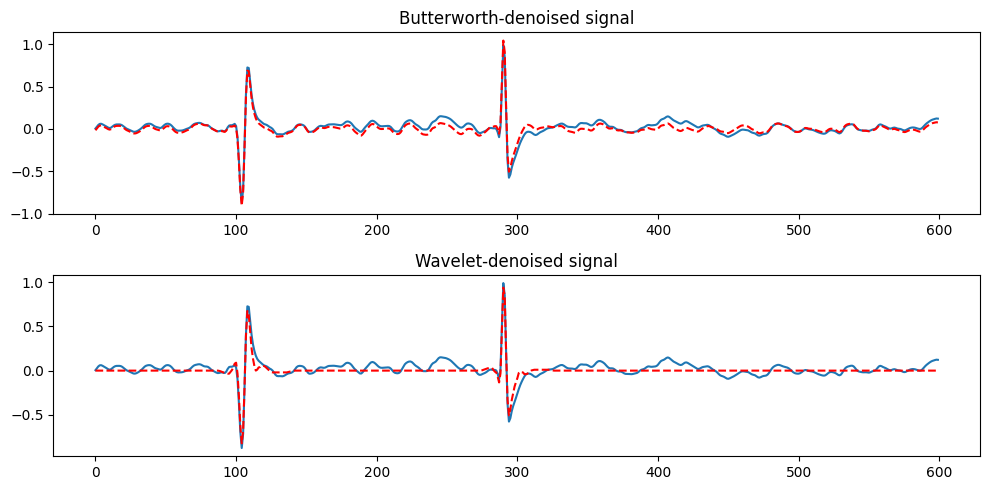

In [14]:
fig = plt.figure(figsize=(10, 5))

# raw
ax = fig.add_subplot(211)
ax.plot(trace[200:800])
ax.set_title("Raw signal")

# denoised
ax.plot(butterworth_filtered.get_traces()[200:800], "--r")
ax.set_title("Butterworth-denoised signal")

# denoised
ax = fig.add_subplot(212)
ax.plot(trace[200:800])

ax.plot(denoised_trace[200:800], "--r")
ax.set_title("Wavelet-denoised signal")


plt.tight_layout()

#### Zoom in 

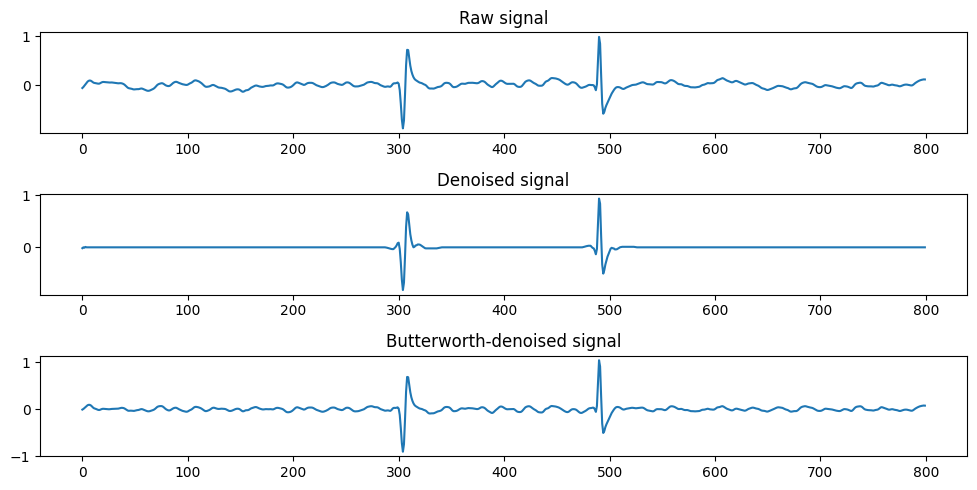

In [15]:
fig = plt.figure(figsize=(10, 5))

# raw
ax = fig.add_subplot(311)
ax.plot(trace[0:800])
ax.set_title("Raw signal")

# denoised
ax = fig.add_subplot(312)
ax.plot(denoised_trace[0:800])
ax.set_title("Denoised signal")

# denoised
ax = fig.add_subplot(313)
ax.plot(butterworth_filtered.get_traces()[0:800])
ax.set_title("Butterworth-denoised signal")

plt.tight_layout()

### (2.2s) Power spectral density

#### (5s) Check Welch's frequency resolution

In [16]:
# Welch method
freqs, powers = signal.welch(
    trace[:size],
    SFREQ,
    window=FILT_WINDOW,
    nperseg=FILT_WIND_SIZE,
    noverlap=FILT_WIND_OVERLAP,
)
print("Welch freq. resolution:", np.sort(freqs)[1] - np.sort(freqs)[0])
print("The upper bound freq. resolution (Fourier's):", SFREQ / trace.shape[0])

Welch freq. resolution: 0.03121951219512195
The upper bound freq. resolution (Fourier's): 0.011111111111111112


#### (40s) Wavelet-denoised PSD

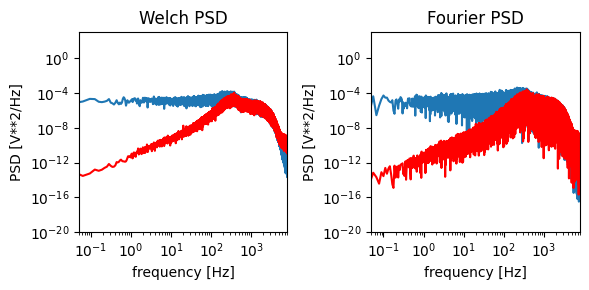

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

YLIM_W = [1e-20, 1e3]
YLIM_F = [1e-20, 1e3]
XLIM = [0.05, SFREQ / 2]

# (4.7s) Welch method
freqs, powers = signal.welch(
    trace[:size],
    SFREQ,
    window=FILT_WINDOW,
    nperseg=FILT_WIND_SIZE,
    noverlap=FILT_WIND_OVERLAP,
)
axes[0].plot(freqs, powers)
axes[0].semilogy(basex=10)
axes[0].semilogx(basey=10)
axes[0].set_ylim(YLIM_W)
axes[0].set_xlim(XLIM)
axes[0].set_xlabel("frequency [Hz]")
axes[0].set_ylabel("PSD [V**2/Hz]")

# Welch method
freqs, powers = signal.welch(
    denoised_trace[:size],
    SFREQ,
    window=FILT_WINDOW,
    nperseg=FILT_WIND_SIZE,
    noverlap=FILT_WIND_OVERLAP,
)
axes[0].plot(freqs, powers, "r")
axes[0].semilogy(basex=10)
axes[0].semilogx(basey=10)
axes[0].set_ylim(YLIM_W)
axes[0].set_xlim(XLIM)
axes[0].set_xlabel("frequency [Hz]")
axes[0].set_ylabel("PSD [V**2/Hz]")
axes[0].set_title("Welch PSD")

# Fourier psd
freqs, powers = signal.periodogram(
    trace[:size],
    fs=SFREQ,
    window="boxcar",
    nfft=None,
    detrend="constant",
    return_onesided=True,
    scaling="density",
    axis=-1,
)

axes[1].plot(freqs, powers)
axes[1].semilogy(basex=10)
axes[1].semilogx(basey=10)
axes[1].set_ylim(YLIM_F)
axes[1].set_xlim(XLIM)
axes[1].set_xlabel("frequency [Hz]")
axes[1].set_ylabel("PSD [V**2/Hz]")

# preprocessed
freqs, powers = signal.periodogram(
    denoised_trace[:size],
    fs=SFREQ,
    window="boxcar",
    nfft=None,
    detrend="constant",
    return_onesided=True,
    scaling="density",
    axis=-1,
)

axes[1].plot(freqs, powers, "r")
axes[1].semilogy(basex=10)
axes[1].semilogx(basey=10)
axes[1].set_ylim(YLIM_F)
axes[1].set_xlim(XLIM)
axes[1].set_xlabel("frequency [Hz]")
axes[1].set_ylabel("PSD [V**2/Hz]")
axes[1].set_title("Fourier PSD")

plt.tight_layout()

#### Butterworth-denoised PSD

Text(0.5, 1.0, 'Fourier PSD')

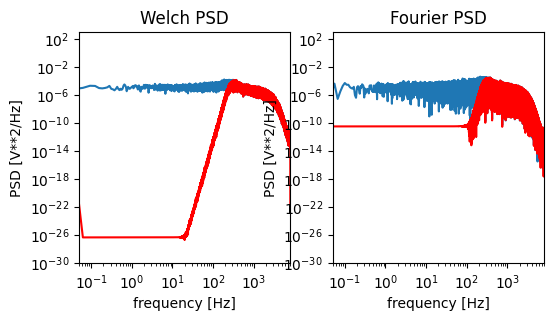

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

YLIM_W = [1e-30, 1e3]
YLIM_F = [1e-30, 1e3]
XLIM = [0.05, SFREQ / 2]

# (4.7s) Welch method
freqs, powers = signal.welch(
    trace[:size],
    SFREQ,
    window=FILT_WINDOW,
    nperseg=FILT_WIND_SIZE,
    noverlap=FILT_WIND_OVERLAP,
)
axes[0].plot(freqs, powers)
axes[0].semilogy(basex=10)
axes[0].semilogx(basey=10)
axes[0].set_ylim(YLIM_W)
axes[0].set_xlim(XLIM)
axes[0].set_xlabel("frequency [Hz]")
axes[0].set_ylabel("PSD [V**2/Hz]")

# Welch method
freqs, powers = signal.welch(
    butterworth_filtered.get_traces()[:size, 0],
    SFREQ,
    window=FILT_WINDOW,
    nperseg=FILT_WIND_SIZE,
    noverlap=FILT_WIND_OVERLAP,
)
axes[0].plot(freqs, powers, "r")
axes[0].semilogy(basex=10)
axes[0].semilogx(basey=10)
axes[0].set_ylim(YLIM_W)
axes[0].set_xlim(XLIM)
axes[0].set_xlabel("frequency [Hz]")
axes[0].set_ylabel("PSD [V**2/Hz]")
axes[0].set_title("Welch PSD")

# Fourier psd
freqs, powers = signal.periodogram(
    trace[:size],
    fs=SFREQ,
    window="boxcar",
    nfft=None,
    detrend="constant",
    return_onesided=True,
    scaling="density",
    axis=-1,
)

axes[1].plot(freqs, powers)
axes[1].semilogy(basex=10)
axes[1].semilogx(basey=10)
axes[1].set_ylim(YLIM_F)
axes[1].set_xlim(XLIM)
axes[1].set_xlabel("frequency [Hz]")
axes[1].set_ylabel("PSD [V**2/Hz]")

# preprocessed
freqs, powers = signal.periodogram(
    butterworth_filtered.get_traces()[:size, 0],
    fs=SFREQ,
    window="boxcar",
    nfft=None,
    detrend="constant",
    return_onesided=True,
    scaling="density",
    axis=-1,
)

axes[1].plot(freqs, powers, "r")
axes[1].semilogy(basex=10)
axes[1].semilogx(basey=10)
axes[1].set_ylim(YLIM_F)
axes[1].set_xlim(XLIM)
axes[1].set_xlabel("frequency [Hz]")
axes[1].set_ylabel("PSD [V**2/Hz]")
axes[1].set_title("Fourier PSD")

# References

(1) https://github.com/steevelaquitaine/wavelet_denoise/blob/master/notebooks/wavelet_denoising.ipynb

(2) Wiltschko, Gage, and Berke, “Wavelet Filtering before Spike Detection Preserves Waveform Shape and Enhances Single-Unit Discrimination.” J Neurosci Methods (2008).

(3) Baldazzi et al., “Systematic Analysis of Wavelet Denoising Methods for Neural Signal Processing.”, Journal of Neural Engineering (2020)